In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import torch
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.estimate import Estimator
from sophius.utils import calc_model_flops
import seaborn as sns
from tqdm import tqdm
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()
estimator = Estimator()

C:\Users\alexander.korolyov\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


Conv2d       (192, 32, 32)  (1, 1)   (1, 1)  
PReLU        (192, 32, 32) 
AvgPool2d    (192, 32, 32)  (3, 3)   (1, 1)  
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            

1.88 MFlops


Loss 81.015: 100%|██████████| 5/5 [04:08<00:00, 49.64s/it]


val_acc: 0.228 train_acc: 0.242
val_acc* 0.288


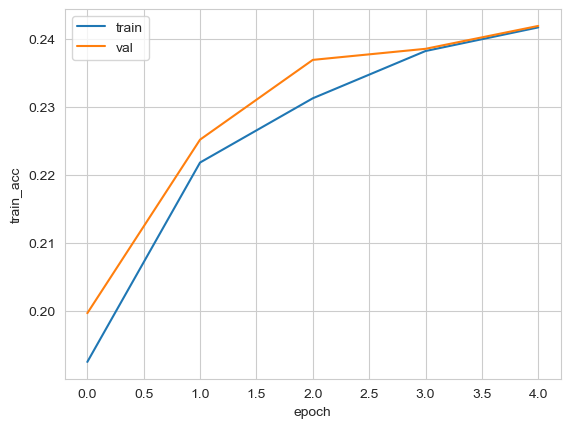

In [3]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=1, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().cuda()

print(model_tmpl)
flops = calc_model_flops(model, model_gen.in_shape)['flops']
print(round(flops / 1024 / 1024, 2), 'MFlops')

train_params = {
    'val_size': 10000,
    'batch_size': 1024,
    'num_epoch': 5,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimator.predict_val_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [4]:
import torch
torch.cuda.get_device_name()

'NVIDIA RTX A500 Laptop GPU'

In [5]:
from sophius.db import *
from peewee import *

with database:
    database.create_tables([Experiments, Models, Devices, Runs, ModelEpochs])

In [6]:
exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}

exp, _ = Experiments.get_or_create(**exp_params)
    
Devices.create_table()
dev, _ = Devices.get_or_create(name=torch.cuda.get_device_name())

In [7]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), out_shape=10, 
    conv_num=1, lin_num=1
)

val_acc_threshold = 0.05

for i in tqdm(range(5)):
    model_tmpl = model_gen.generate_model_tmpl()
    model_gpu = model_tmpl.instantiate_model().cuda()
    
    if estimator.predict_val_acc(model_tmpl) < val_acc_threshold:
        continue
    
    model_info = calc_model_flops(model_gpu, model_gen.in_shape)        
    model, _ = Models.get_or_create(
        hash = encoder.model2hash(model_tmpl),
        flops = model_info['flops'],
        macs = model_info['macs'],
        params = model_info['params'],
    )
        
    epoch_results = train_on_gpu_ex(
        model=model_gpu,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    run = Runs.create(
        exp_id = exp.id,
        model_id = model.id,
        device_id = dev.id,
        val_acc = epoch_results.val_acc.iloc[-10:].mean(),
        train_acc = epoch_results.train_acc.iloc[-10:].mean(),
        time = epoch_results.time.iloc[-1],
    )

    for _, row in epoch_results.iterrows():
        ModelEpochs.create(
            run_id = run.id,
            loss = row['loss'],
            train_acc = row['train_acc'],
            val_acc = row['val_acc'],
            time = row['time'],
        )    

100%|██████████| 5/5 [00:11<00:00,  2.39s/it]
